# Handwritten-Digit-Classification
This code uses PyTorch to build and implement a residual CNN for solving a classification problem. Our goal is to classify handwritten digits from 0 to 9 on the MNIST dataset. You can try larger and more fun datasets if you have access to Google Colab. (for example: [facial emotion detection](https://www.kaggle.com/datasets/msambare/fer2013))
We use MNIST in this example.

For more information please read the [data documentation](https://www.kaggle.com/datasets/hojjatk/mnist-dataset).

* It is highly recommended to run this notebook on Google Colab so that you can utilize its GPU.


# Setup

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, datasets

from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.metrics import confusion_matrix

plt.style.use('ggplot')



In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Prepare The Data

Write a composed transformation to transform our dataset's PIL images to tensors and normalize them with ```mean: 0.1307``` and ```std: 0.3081```: 

<details>
<summary>Hint</summary>
<br>
<a href="https://pytorch.org/vision/stable/generated/torchvision.transforms.Compose.html">torchvision.transforms.Compose</a>
</details>

In [3]:
###############################################################
##                Compose your transformations               ##
###############################################################
transformation = transform=transforms.Compose([
                                                transforms.ToTensor(), # convert image to tensor
                                                transforms.Normalize((0.1307,), (0.3081,)) # normalize inputs
                                            ])

Split the downloaded MNIST dataset into two dataloaders ```train``` & ```val```

In [4]:
# Download the MNIST dataset
mnist_data = datasets.MNIST(root='data/', download=True, transform=transformation)

# Number of images in the dataset: 60,000
print(len(mnist_data))

# Split the dataset into training and validation sets
train_data, valid_data = random_split(mnist_data, [50000, 10000]) 

60000


Create dataloaders for your train and validation data with ```batch size 16``` and ```shuffle = True``` for train loader.

<details>
<summary>Hint</summary>
<br>
<a href="https://pytorch.org/tutorials/beginner/basics/data_tutorial.html">DATASETS & DATALOADERS</a>
</details>

In [21]:
###############################################################
##           Load the datasets into train/valid              ##
##                       dataloaders                         ##
###############################################################
BATCH_SIZE=20
train_loader = DataLoader(train_data,batch_size=BATCH_SIZE,shuffle=True)
val_loader = DataLoader(valid_data,batch_size=BATCH_SIZE,shuffle=True)

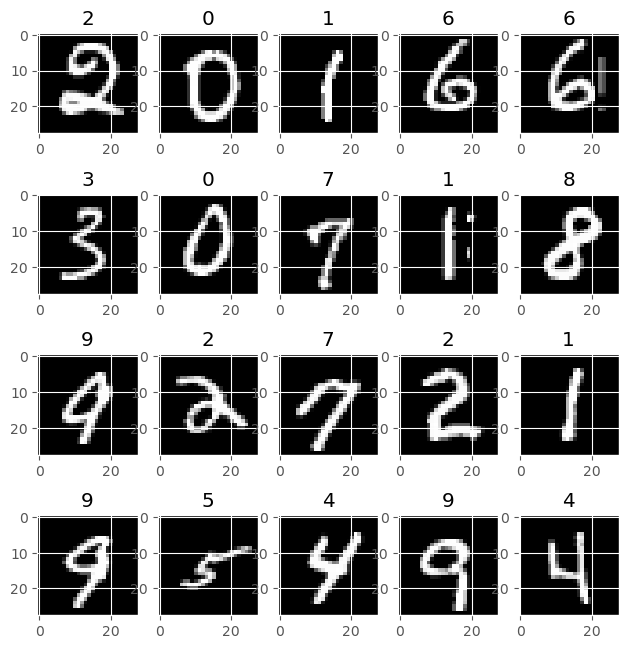

In [22]:
# obtain one batch of training images
images, labels = next(iter(train_loader))
images = images.numpy()
num = 20
num_row = 4
num_col = 5
fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
# # plot the images in the batch, along with corresponding labels
for i in np.arange(num):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(np.squeeze(images[i]), cmap='gray')
    ax.set_title(labels[i].item())

plt.show()



# Define Model

### You need to implement a model with the architecture below:
[Input: (BS, 1, 28, 28)] -- > [Conv2D (BS, 16, 28, 28)] --> ReLU --> [MaxPool2D (BS, 16, 14, 14): Residual1]

--> [Conv2D (BS, 16, 14, 14)] --> ReLU --> [Conv2D (BS, 16, 14, 14)] --> ReLU --> [Addition with Residual1]

--> [MaxPool2D (BS, 16, 7, 7)] --> [Conv2D (BS, 64, 7, 7)] --> [ReLU: Residual2]

--> [Conv2D (BS, 64, 7, 7)] --> ReLU --> [Conv2D (BS, 64, 7, 7)] --> ReLU --> [Addition with Residual2]

--> [GlobalAveragePooling (BS, 64, 1, 1)] --> [Flatten (BS, 64)] --> [Linear (BS, 10)] --> ReLU --> OUT

Here you can see the drawn schematic of the architecture, too:

![architecture](/Architecture.png)

<details>
<summary>Hint</summary>
<br>
These might be helpful:
<br>
<a href="https://pytorch.org/docs/stable/generated/torch.clone.html">TORCH.CLONE</a>
<br><br>
<a href="https://pytorch.org/docs/master/generated/torch.nn.AdaptiveAvgPool2d.html#torch.nn.AdaptiveAvgPool2d">AdaptiveAvgPool2d</a> with output size (1, 1) for global average pooling
<br><br>
<a href="https://arxiv.org/pdf/1512.03385.pdf">Deep Residual Learning for Image Recognition</a>
</details>

In [296]:
#####################################
##           Define model          ##
#####################################
class ResidualClassifier(nn.Module):
    def __init__(self):
        
        super(ResidualClassifier,self).__init__()
        self.conv1=nn.Conv2d(in_channels=1,out_channels=16,kernel_size=5,padding=2)
        self.pool1=nn.MaxPool2d(kernel_size=2,stride=2)
    

        self.conv2=nn.Conv2d(in_channels=16,out_channels=16,kernel_size=5,padding=2)

        self.conv3=nn.Conv2d(in_channels=16,out_channels=64,kernel_size=5,padding=2)
        self.conv4=nn.Conv2d(in_channels=64,out_channels=64,kernel_size=5,padding=2)
        self.avg=nn.AdaptiveAvgPool2d(1)
        self.linear=nn.Linear(in_features=64,out_features=10)
        
        
    def forward(self, x):
        x=F.relu(self.conv1(x))
        x=self.pool1(x)
        residual_1=torch.clone(x)
        x=F.relu(self.conv2(x))
        x=F.relu(self.conv2(x))
        x=x+residual_1
        
        x=self.pool1(x)
        x=F.relu(self.conv3(x))
        residual_2=torch.clone(x)
        X=F.relu(self.conv4(x))
        X=F.relu(self.conv4(x))
        x=x+residual_2
        x=self.avg(x)
        x=torch.flatten(x,start_dim=1)
        x=self.linear(x)
        x=F.relu(x)
        return x

# Train Model

In [297]:
######################################################################
##        Instantiate model, define hyper parameters, optimizer,    ##
##        loss function and etc                                     ##
######################################################################
model = ResidualClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),lr=0.003,momentum=0.9)

In [298]:
######################################################################
##        Train your model                                          ##
######################################################################
total_step = len(train_loader)
num_epochs = 10
t_acc=[0]*num_epochs
t_loss=[0]*num_epochs
v_loss=[0]*num_epochs
v_acc=[0]*num_epochs

for epoch in range(num_epochs):
    train_loss, train_acc = 0, 0
    i=0
    N=0
    for images, labels in train_loader:
        i+=1
        images, labels = images.to(device), labels.to(device)
        output=model(images)
        loss=criterion(output,labels)
        N+=images.shape[0]
       # Backward and optimize
        optimizer.zero_grad()
        t_loss[epoch]+=loss.item()/total_step
        t_acc[epoch]+= labels.eq(torch.argmax(output, 1)).sum().item()/(len(train_loader)*BATCH_SIZE)
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
             print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                       .format(epoch + 1, num_epochs,   i+1, total_step, t_acc[epoch]))


    with torch.no_grad():
        correct_count=0
        val_loss = 0
        accuracy = 0
        for images, labels in val_loader:
             print(images.shape)
             images, labels = images.to(device), labels.to(device)
             output=model(images)
            
             loss=criterion(output,labels)
             v_loss[epoch]+= loss.item()*images.shape[0] / len(val_loader)
             
             predicted_targets = output.argmax(dim=1)
            
             correct_count += (predicted_targets == labels).sum().item()
             print(correct_count)

        
        v_acc[epoch]=correct_count/(len(val_loader)*BATCH_SIZE)

    print(f"[Epoch {epoch+1}]\t"
        f"val Loss: {v_loss[epoch]:.4f}\t"
        f"val Accuracy: {v_acc[epoch]*100:.2f}")

Epoch [1/10], Step [100/3125], Loss: 0.0054
Epoch [1/10], Step [200/3125], Loss: 0.0117
Epoch [1/10], Step [300/3125], Loss: 0.0194
Epoch [1/10], Step [400/3125], Loss: 0.0282
Epoch [1/10], Step [500/3125], Loss: 0.0374
Epoch [1/10], Step [600/3125], Loss: 0.0477
Epoch [1/10], Step [700/3125], Loss: 0.0612
Epoch [1/10], Step [800/3125], Loss: 0.0777
Epoch [1/10], Step [900/3125], Loss: 0.0973
Epoch [1/10], Step [1000/3125], Loss: 0.1206
Epoch [1/10], Step [1100/3125], Loss: 0.1459
Epoch [1/10], Step [1200/3125], Loss: 0.1706
Epoch [1/10], Step [1300/3125], Loss: 0.1956
Epoch [1/10], Step [1400/3125], Loss: 0.2220
Epoch [1/10], Step [1500/3125], Loss: 0.2480
Epoch [1/10], Step [1600/3125], Loss: 0.2743
Epoch [1/10], Step [1700/3125], Loss: 0.3004
Epoch [1/10], Step [1800/3125], Loss: 0.3269
Epoch [1/10], Step [1900/3125], Loss: 0.3539
Epoch [1/10], Step [2000/3125], Loss: 0.3810
Epoch [1/10], Step [2100/3125], Loss: 0.4077
Epoch [1/10], Step [2200/3125], Loss: 0.4353
Epoch [1/10], Step 

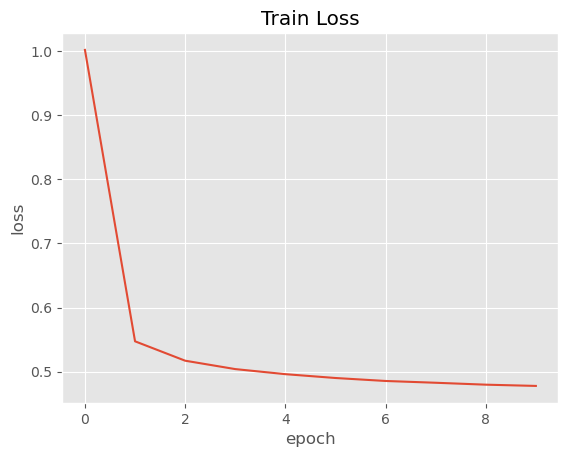

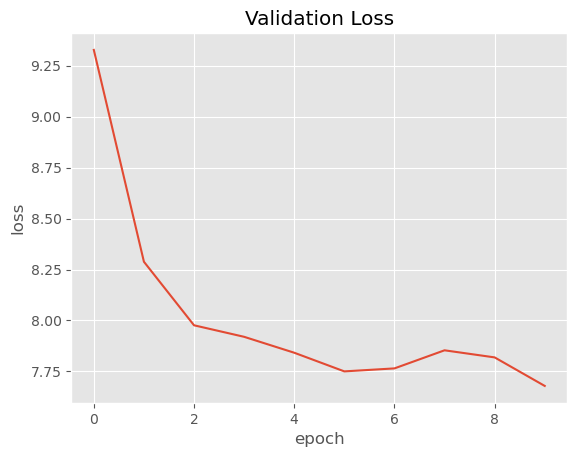

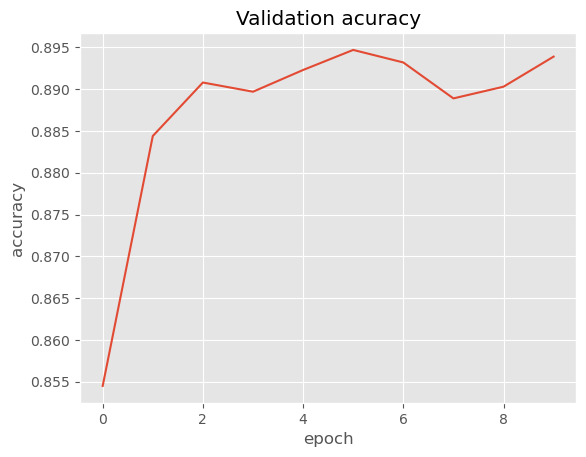

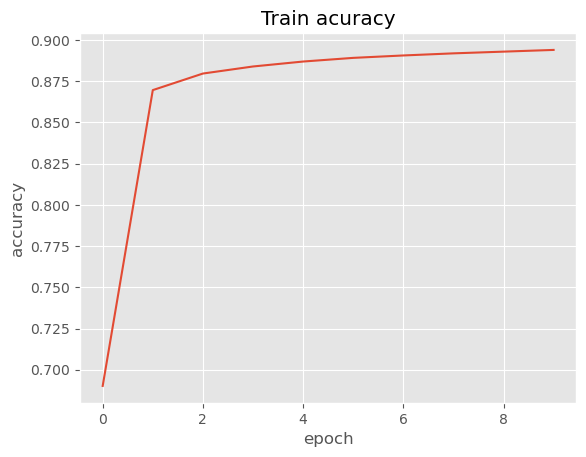

0.8939


In [299]:
##############################################################
##          Plot metrics graph for different epochs         ##
##############################################################
plt.plot(t_loss)
plt.xlabel('epoch') 
# naming the y axis 
plt.ylabel('loss') 
    
# giving a title to my graph 
plt.title('Train Loss') 
    
# function to show the plot 
plt.show() 

plt.plot(v_loss)
plt.xlabel('epoch') 
# naming the y axis 
plt.ylabel('loss') 
    
# giving a title to my graph 
plt.title('Validation Loss') 
    
# function to show the plot 
plt.show() 

plt.plot(v_acc)
plt.xlabel('epoch') 
# naming the y axis 
plt.ylabel('accuracy') 
    
# giving a title to my graph 
plt.title('Validation acuracy') 
    
# function to show the plot 
plt.show() 



plt.plot(t_acc)
plt.xlabel('epoch') 
# naming the y axis 
plt.ylabel('accuracy') 
    
# giving a title to my graph 
plt.title('Train acuracy') 
    
# function to show the plot 
plt.show() 
print(v_acc[9])

# Test Model

10000
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Number Of Images Tested = 10000

Model test Accuracy = 0.8916


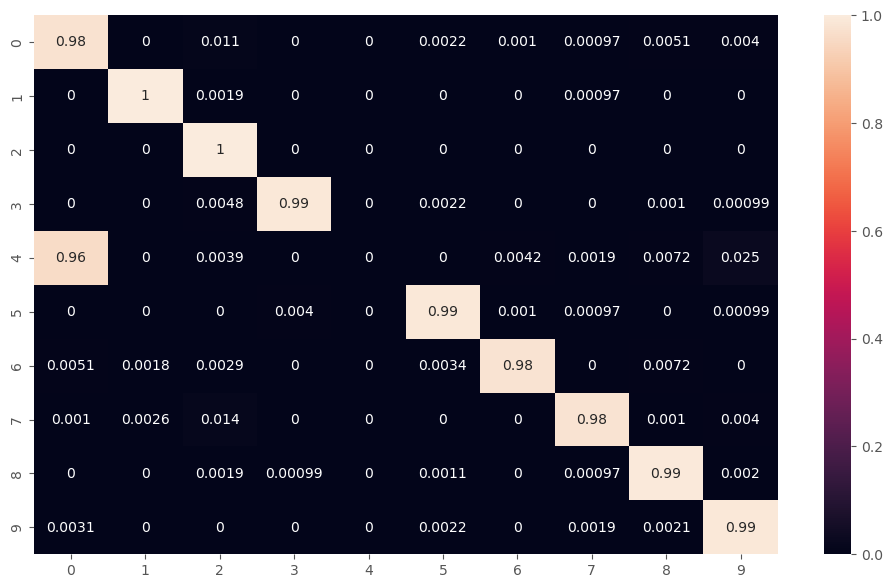

In [300]:
##################################################
##          Test your model on test-set         ##
##          and plot confusion matrix           ##
##################################################

test_data = datasets.MNIST(root='data/', download=True, transform=transformation, train=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)
print(len(test_data))
N=0
correct_count, all_count = 0, len(test_data)
y_pred = []
y_true = []
with torch.no_grad():
           
        for images,labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs=model(images)
            N+= images.shape[0]
            loss_f=criterion(outputs,labels)
            predicted_targets = outputs.argmax(dim=1)
            y_pred.extend(predicted_targets.cpu())
            y_true.extend(labels.cpu())
            correct_count += (predicted_targets == labels).sum().item()
        cf_matrix = confusion_matrix(y_true, y_pred)
        classes=[i for i in range(10)]
        print (classes)
        df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1), index = [i for i in classes],
                     columns = [i for i in classes])
        plt.figure(figsize = (12,7))
        sn.heatmap(df_cm, annot=True) 

        print("Number Of Images Tested =", all_count)
        print("\nModel test Accuracy =", (correct_count/all_count))


simple Test 10 data

In [301]:
sample = next(iter(test_loader))
imgs, lbls = sample

actual_number = lbls[:10].numpy()
actual_number

array([7, 2, 1, 0, 4, 1, 4, 9, 5, 9], dtype=int64)

In [302]:
lbls,imgs=lbls.to(device),imgs.to(device)
test_output = model(imgs[:10])
pred_y = torch.max(test_output, 1)[1].data.cpu().numpy().squeeze()
print(f'Prediction number: {pred_y}')
print(f'Actual number: {actual_number}')

Prediction number: [7 2 1 0 0 1 0 9 5 9]
Actual number: [7 2 1 0 4 1 4 9 5 9]
